### Dynamic programming approach to solve the mountain car problem

In [ ]:

import numpy as np
import gym
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
import pandas as pd



In [119]:
env = gym.make('MountainCar-v0')
env.reset()

other_stats = {'reached_goal_episodes':[], 'ave_moves_to_success':[],'highest_positions':[], 'largest_velocities':[]}

/usr/local/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [120]:
def plot_results(x,y,x_label,y_label,title):
    """
    Plot results for each function 
    :param x: [] list of values to display along X axis
    :param y: [] list of values to display  along Y axis
    :param x_label: Str name of the x axis
    :param y_label: Str name of the y axis
    :param title : Str title of the chart
    """
    plt.plot(x,y) 
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title) 
    plt.show()
    plt.close()

In [121]:
def Qlearning(env,learning,discount,epsilon,min_eps,episodes,other_stats):
    local_stats = {'reached_goal': 0, 'current_moves':0,'moves_to_success':[],'highest_position':-1.2,'largest_velocity':-0.07}
    num_states = (env.observation_space.high - env.observation_space.low)*np.array([10, 100])
    num_states = np.round(num_states, 0).astype(int) + 1
    # Initialize Q table
    Q = np.random.uniform(low = -1, high = 1,size = (num_states[0], num_states[1],env.action_space.n))
    # Initialize variables to track rewards
    reward_list = []
    ave_reward_list = []
    # Calculate episodic reduction in epsilon
    reduction = (epsilon - min_eps)/episodes
    # Run Q learning algorithm
    for i in range(episodes):
        # Initialize parameters
        done = False
        tot_reward, reward = 0,0
        state = env.reset()
        
        # Discretize state
        state_adj = (state - env.observation_space.low)*np.array([10, 100])
        state_adj = np.round(state_adj, 0).astype(int)
        while done != True:
            # Render environment for last five episodes
            #if i >= (episodes - 20):
            #    env.render()
            
            # Determine next action - epsilon greedy strategy
            if np.random.random() < 1 - epsilon:
                action = np.argmax(Q[state_adj[0], state_adj[1]])
            else:
                action = np.random.randint(0, env.action_space.n)
            
       
            # Get next state and reward
            state2, reward, done, info = env.step(action)
            # Discretize state2
            state2_adj = (state2 - env.observation_space.low)*np.array([10, 100])
            state2_adj = np.round(state2_adj, 0).astype(int)
            if(state2[0] > local_stats['highest_position']):
                local_stats['highest_position'] = state2[0]
            
            if(state2[1] > local_stats['largest_velocity']):
                local_stats['largest_velocity'] = state2[1]
         
            
            #Count only moves 
            if action != 1:
                local_stats['current_moves'] += 1
            
            # Check if we reached the goal 
            if done and state2[0] >= 0.5:
                local_stats['reached_goal'] +=1
                local_stats['moves_to_success'].append(local_stats['current_moves'])
                local_stats['current_moves'] = 0
                Q[state_adj[0], state_adj[1], action] = reward

            
    
                
            # Adjust Q value for current state
            else:
                delta = learning*(reward + discount*np.max(Q[state2_adj[0],state2_adj[1]]) - Q[state_adj[0], state_adj[1],action])
                Q[state_adj[0], state_adj[1],action] += delta
            
            # Update variables
            tot_reward += reward
            state_adj = state2_adj
            
        # Decay epsilon
        if epsilon > min_eps:
            epsilon -= reduction
        
        
        # Track rewards
        reward_list.append(tot_reward)
        
        if (i+1) % 100 == 0:
            ave_reward = np.mean(reward_list) 
            ave_reward_list.append(ave_reward) 
            reward_list = []
            other_stats['reached_goal_episodes'].append(local_stats['reached_goal'])
            other_stats['highest_positions'].append(local_stats['highest_position'])
            other_stats['largest_velocities'].append(local_stats['largest_velocity'])
            if(len(local_stats['moves_to_success']) >0):
                other_stats['ave_moves_to_success'].append(np.mean(local_stats['moves_to_success']))
            else: 
                other_stats['ave_moves_to_success'].append(0)
            local_stats = {'reached_goal': 0, 'current_moves':0,'moves_to_success':[],'highest_position':-1.2,'largest_velocity':-0.07}

        
        #if (i+1) % 100 == 0:
           # print('Episode {} Average Reward: {}'.format(i+1, ave_reward))
            
    env.close()
    return ave_reward_list,other_stats

    

## Initial run 

### Run experiment and plot values

In [122]:
# Run Q-learning algorithm
rewards,other_stats = Qlearning(env, 0.2, 0.9, 0.8, 0, 5000,other_stats)



### Plot all results

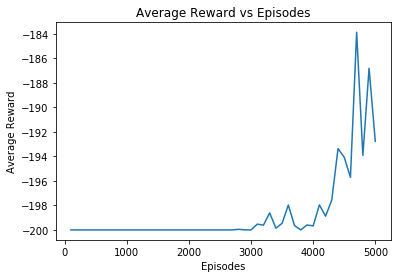

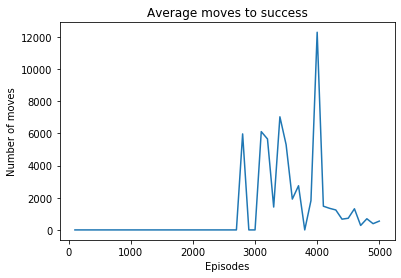

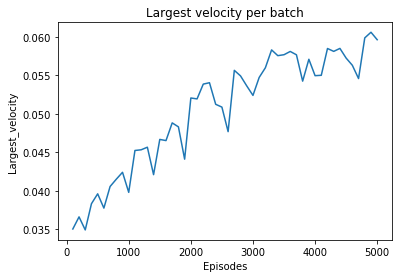

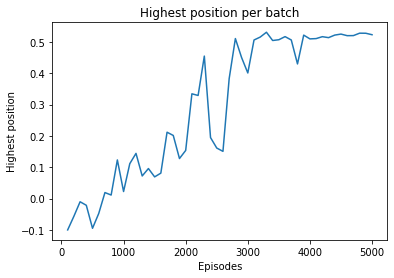

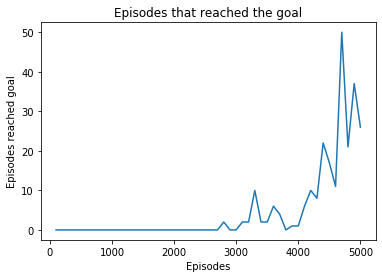

In [123]:
episodes = 100*(np.arange(len(rewards)) + 1)
plot_results(episodes,rewards, 'Episodes','Average Reward','Average Reward vs Episodes')
plot_results(episodes,other_stats['ave_moves_to_success'], 'Episodes','Number of moves','Average moves to success')
plot_results(episodes,other_stats['largest_velocities'], 'Episodes','Largest_velocity','Largest velocity per batch')
plot_results(episodes,other_stats['highest_positions'], 'Episodes','Highest position','Highest position per batch')
plot_results(episodes,other_stats['reached_goal_episodes'], 'Episodes','Episodes reached goal','Episodes that reached the goal')







###  Parameter tuning
#### Explore learning rate 







In [124]:
leraning_rate = [0.01,0.05,0.1,0.3,0.5] # Try a range of learning rate values
reward_per_option = {} # Dictionary, accumulate results per each learning rate option 
#Initialize Dictionary
for lr in leraning_rate:
    reward_per_lr[lr] = []

for lr in leraning_rate:
    rewards,other_stats = Qlearning(env, lr, 0.9, 0.8, 0, 5000,other_stats)
    reward_per_option[lr] = rewards
 
    

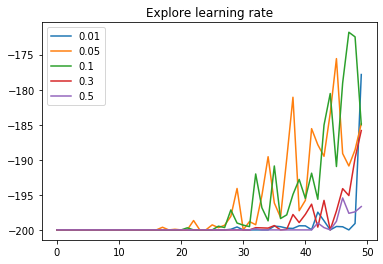

In [125]:
episodes = 100*(np.arange(len(reward_per_option)) + 1)  
df = pd.DataFrame(reward_per_option)
ax = plt.gca()
for lr in leraning_rate:
    df.plot(y=lr,ax=ax,title="Explore learning rate")

#### Explore discount options

In [126]:
discount_options = [0.01,0.1,0.5,0.95,0.99]
reward_per_option = {} 
#Initialize Dictionary
for do in discount_options:
    reward_per_option[do] = []

for do in discount_options:
    rewards,other_stats = Qlearning(env, 0.2, do, 0.8, 0, 5000,other_stats)
    reward_per_option[do] = rewards

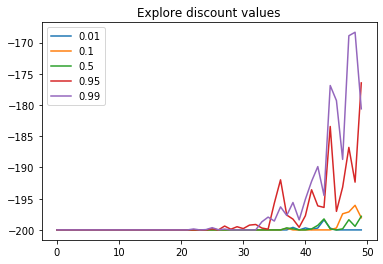

In [127]:
df = pd.DataFrame(reward_per_option)
ax = plt.gca()
for do in discount_options:
    df.plot(y=do,ax=ax,title="Explore discount values")

#### Explore epsilon options

In [128]:
eps_options = [0.01,0.1,0.5,0.95,0.99]
reward_per_option = {} 
#Initialize Dictionary
for eps in eps_options:
    reward_per_option[eps] = []

for eps in eps_options:
    rewards,other_stats = Qlearning(env, 0.2, 0.9, eps, 0, 5000,other_stats)
    reward_per_option[eps] = rewards

KeyError: 0.95

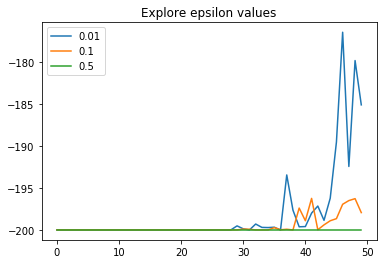

In [150]:
df = pd.DataFrame(reward_per_option)
ax = plt.gca()
for eps in eps_options:
    df.plot(y=eps,ax=ax,title="Explore epsilon values")
  

#### Explore min_eps options

In [133]:
mineps_options = [0.005,0.01,0.05,0.1,0.2,0.5]
reward_per_option = {}  
#Initialize Dictionary
for mineps in mineps_options:
    reward_per_option[mineps] = []

for mineps in mineps_options:
    rewards,other_stats = Qlearning(env, 0.2, 0.9, 0.8, mineps, 5000,other_stats)
    reward_per_option[mineps] = rewards

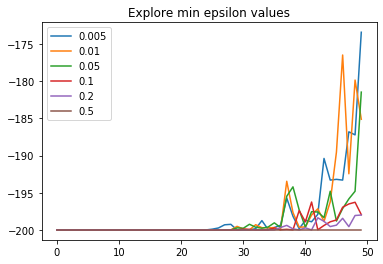

In [153]:
df = pd.DataFrame(reward_per_option)
ax = plt.gca()
for mineps in reward_per_option:
    df.plot(y=mineps,ax=ax,title="Explore min epsilon values")